# Environment

In [1]:
# !conda update -n base -c conda-forge conda -y
# !conda install -n pytorch_p310 -c conda-forge "cuda-version=12.5" "cudnn=9.3.*" -y
# !python -m pip install --upgrade pip setuptools wheel
# !pip install --upgrade tensorflow==2.19.1 keras==3.6.0 ml-dtypes==0.5.1 keras-hub --only-binary=:all:
# !pip install wordcloud keras-cv keras-nlp tfclip tensorflow-hub tensorflow-text optuna ftfy albumentationsx

In [2]:
import os, sys
import tensorflow as tf

# Prepend conda lib path so TF sees the newly installed cuDNN
conda_env = "pytorch_p310"
try:
    import subprocess, json
    envs = subprocess.check_output(["conda", "env", "list", "--json"]).decode()
    envs = json.loads(envs)
    lib_path = None
    for p in envs.get("envs", []):
        if p.endswith(conda_env):
            lib_path = os.path.join(p, "lib")
            break
    if lib_path and os.path.isdir(lib_path):
        os.environ["LD_LIBRARY_PATH"] = lib_path + os.pathsep + os.environ.get("LD_LIBRARY_PATH", "")
except Exception:
    pass

print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

# Try a quick cuDNN op to confirm
try:
    with tf.device("GPU:0"):
        x = tf.random.normal([1, 32, 224, 224, 3])
        x = tf.reduce_mean(x)
    print("TF OK on GPU; cuDNN likely loaded.")
except Exception as e:
    print("GPU/cuDNN check failed:", e)


2025-10-09 05:40:30.050375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 05:40:30.067663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759988430.088199   31564 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759988430.094469   31564 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759988430.110245   31564 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1759988434.029724   31564 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


TF OK on GPU; cuDNN likely loaded.


In [3]:
import os
import tensorflow as tf
from tfclip import create_model_and_transforms

# Ensure GPU is visible
print("GPUs:", tf.config.list_physical_devices("GPU"))
assert tf.config.list_physical_devices("GPU"), "No GPU detected by TensorFlow."

# Limit memory growth to avoid OOMs
for gpu in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# !pip install tfclip ftfy

In [5]:
# !python -m pip install --upgrade pip setuptools wheel
# !pip install --upgrade tensorflow==2.19.1 keras==3.6.0 ml-dtypes==0.5.1 tfclip --only-binary=:all:

In [6]:
# !pip install wordcloud tfclip tensorflow-hub tensorflow-text optuna ftfy albumentationsx

In [7]:
# !pip install --upgrade keras-hub

In [8]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # must be set BEFORE importing keras/*

In [9]:
import tensorflow as tf
import keras
# import keras_hub

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List all physical devices
print("\nAll devices:")
print(tf.config.list_physical_devices())

Num GPUs Available:  1

All devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
import os, json, hashlib, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud, STOPWORDS

print("TF:", tf.__version__)

TF: 2.19.1


In [11]:
# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


# Paths & Load data

In [12]:
DATA_DIR = "./A2_Data"
JSONL   = os.path.join(DATA_DIR, "A2_train_v3.jsonl")
IMAGE_DIR = os.path.join(DATA_DIR, "A2_Images")
df = pd.read_json(JSONL, lines=True)
assert set(["Image_ID","Label","Hypothesis","Premise"]).issubset(df.columns), df.columns

# Resolve image paths (try common extensions)
EXTS = [".jpg", ".jpeg", ".png", ".JPG", ".PNG"]
def resolve_image_path(image_id, root=IMAGE_DIR, exts=EXTS):
    sid = str(image_id).strip()
    for e in exts:
        p = os.path.join(root, sid + e)
        if os.path.isfile(p):
            return p
    return None


In [13]:
# e.g. sample 20% from each label
df = df.groupby("Label", group_keys=False).apply(lambda x: x.sample(frac=0.3, random_state=42))


/tmp/ipykernel_31564/4188747377.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Label", group_keys=False).apply(lambda x: x.sample(frac=0.3, random_state=42))


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11739 entries, 29503 to 28566
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_ID    11739 non-null  int64 
 1   Label       11739 non-null  object
 2   Hypothesis  11739 non-null  object
 3   Premise     11739 non-null  object
dtypes: int64(1), object(3)
memory usage: 458.6+ KB


In [15]:
df["image_path"] = df["Image_ID"].apply(resolve_image_path)
missing_before = df["image_path"].isna().sum()
if missing_before:
    print(f"[WARN] {missing_before} rows have no matching image file. Dropping them.")
df = df.dropna(subset=["image_path"]).reset_index(drop=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11739 entries, 0 to 11738
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_ID    11739 non-null  int64 
 1   Label       11739 non-null  object
 2   Hypothesis  11739 non-null  object
 3   Premise     11739 non-null  object
 4   image_path  11739 non-null  object
dtypes: int64(1), object(4)
memory usage: 458.7+ KB


# Exploratory Data Analysis

In [17]:
import os, re, math, random, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps

# Optional deep EDA (text+image similarity)
DO_DEEP_SIM = True
try:
    import tensorflow as tf, tensorflow_hub as hub, tensorflow_text  # noqa
    # import keras_hub as kh
except Exception:
    DO_DEEP_SIM = False
    print("[INFO] Deep similarity (USE/CLIP) disabled — missing TF deps. Install if you want those plots.")

# -----------------------
# Config
# -----------------------
DATA_FILE   = "./A2_Data/train.csv"     # accepts .csv, .tsv, .jsonl
IMAGE_ROOT  = "./A2_Data/A2_Images"
SEED = 42
BATCH_SIZE = 64
random.seed(SEED); np.random.seed(SEED)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [18]:
# Optional deep EDA (text+image similarity)
import os

def count_images(root_dir, exts=None, show_breakdown=True):
    """
    Recursively count image files in `root_dir`.

    Args:
        root_dir (str): Path to scan.
        exts (list[str] | None): Allowed extensions (case-insensitive).
                                 Defaults to common image formats.
        show_breakdown (bool): Whether to print counts per extension.

    Returns:
        total (int): Total number of image files found.
    """
    if exts is None:
        exts = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif", ".webp"]

    # Normalize to lowercase for matching
    exts = [e.lower() for e in exts]
    counts = {e: 0 for e in exts}
    total = 0

    for root, _, files in os.walk(root_dir):
        for f in files:
            _, ext = os.path.splitext(f)
            ext = ext.lower()
            if ext in exts:
                counts[ext] += 1
                total += 1

    if show_breakdown:
        print(f"\nImage counts under: {root_dir}")
        for e, c in counts.items():
            print(f"  {e:>6}: {c}")
        print(f"  Total: {total}")

    return total

total = count_images(IMAGE_ROOT)
print(f"\nTotal images found: {total}")



Image counts under: ./A2_Data/A2_Images
    .jpg: 19573
   .jpeg: 0
    .png: 0
    .bmp: 0
   .tiff: 0
    .gif: 0
   .webp: 0
  Total: 19573

Total images found: 19573


In [19]:
df["Label"] = df["Label"].astype(str).str.strip().str.lower()
valid_labels = {"entailment","contradiction","neutral"}
unknown = set(df["Label"].unique()) - valid_labels
if unknown:
    print("[WARN] Found unknown labels:", unknown)

# Stable label map
label_names = sorted([l for l in df["Label"].unique() if l in valid_labels])
label2id = {n:i for i,n in enumerate(label_names)}
df["label_id"] = df["Label"].map(label2id)

In [20]:
def show_bar(series, title, xlabel, ylabel="Count", rot=45, figsize=(7,4)):
    plt.figure(figsize=figsize)
    series.plot(kind="bar")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xticks(rotation=rot); plt.tight_layout(); plt.show()

def simple_tokenize(s):
    return [t for t in re.split(r"[^a-z0-9]+", str(s).lower()) if t]

def negation_count(s):
    # crude but useful: captures typical negation cues
    terms = ["no","not","never","none","nobody","nothing","nowhere","neither","nor","cannot","can't","won't","n't"]
    toks = simple_tokenize(s)
    return sum(tok in terms for tok in toks)


[EDA] Label distribution
Label
entailment       5886
contradiction    5853
Name: count, dtype: int64


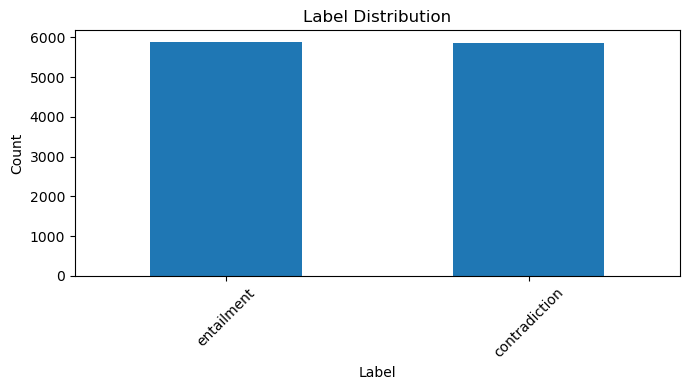

Imbalance ratio (max/min): 1.01


In [21]:
print("\n[EDA] Label distribution")
lbl_counts = df["Label"].value_counts()
print(lbl_counts)
show_bar(lbl_counts, "Label Distribution", "Label")
print(f"Imbalance ratio (max/min): {lbl_counts.max()/max(1,lbl_counts.min()):.2f}")

In [22]:
print("\n[EDA] Conflicting labels for the SAME Image_ID")
conflict_counts = (
    df.groupby("Image_ID")["Label"]
      .nunique()
      .reset_index(name="n_labels")
      .query("n_labels > 1")
)
print(f"Images with multiple labels: {len(conflict_counts)}")
if len(conflict_counts):
    # Show a few examples with all their rows
    sample_ids = conflict_counts["Image_ID"].head(3).tolist()
    print("\nExamples (first 3 Image_IDs with conflicts):")
    print(df[df["Image_ID"].isin(sample_ids)]
          .sort_values(["Image_ID","Label"])
          [["Image_ID","Label","Hypothesis","Premise"]]
          .head(12)
          .to_string(index=False))


[EDA] Conflicting labels for the SAME Image_ID
Images with multiple labels: 1117

Examples (first 3 Image_IDs with conflicts):
 Image_ID         Label                                                       Hypothesis                                                                                        Premise
  3787801 contradiction                                             A man taking photos.                                                A young man reviews photos at his work station.
  3787801    entailment                                           A man studying photos.                                                A young man reviews photos at his work station.
  4162702 contradiction                   Two ladies are eating food while sitting down.                                              Two women wearing blue jeans are walking outside.
  4162702    entailment                                 Two ladies in pants are walking.                                              Tw

### Duplicates Leakage Check

In [23]:
import pandas as pd
from tqdm import tqdm
import hashlib

# 1️⃣ Compute MD5 hashes if you haven’t already
def md5_file(path, chunk_size=8192):
    try:
        h = hashlib.md5()
        with open(path, "rb") as f:
            while chunk := f.read(chunk_size):
                h.update(chunk)
        return h.hexdigest()
    except Exception as e:
        return None  # missing / unreadable file

if "image_md5" not in df.columns:
    tqdm.pandas(desc="Hashing images")
    df["image_md5"] = df["image_path"].astype(str).progress_apply(md5_file)

# 2️⃣ Find groups of identical hashes with different Image_IDs
dupe_groups = (
    df.groupby("image_md5")
      .agg({"Image_ID": pd.Series.nunique, "image_path": list})
      .reset_index()
)

# Keep only those where multiple Image_IDs share same hash
dupe_groups = dupe_groups[dupe_groups["Image_ID"] > 1]

print(f"🧩 Found {len(dupe_groups)} duplicate hash groups (same image, different ID)")

# 3️⃣ For each hash, print which Image_IDs share it
for _, row in dupe_groups.iterrows():
    md5 = row["image_md5"]
    # subset rows that share this hash
    subset = df[df["image_md5"] == md5][["Image_ID", "image_path"]].drop_duplicates()
    print("\n🔁 Duplicate image content group:")
    print(f"Hash: {md5}")
    print(subset.to_string(index=False))

Hashing images: 100%|██████████| 11739/11739 [00:03<00:00, 3750.75it/s]


🧩 Found 0 duplicate hash groups (same image, different ID)


In [24]:
import pandas as pd

# 1️⃣ Count how many times each Image_ID appears
img_counts = (
    df["Image_ID"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Image_ID", "Image_ID": "count"})
)

# 2️⃣ Keep only images used more than once
reused = img_counts[img_counts["count"] > 1]

print(f"🧩 Found {len(reused)} images used multiple times (total rows: {len(df)})")
print(reused.dropna()) 

🧩 Found 9556 images used multiple times (total rows: 11739)
           count  count
0     3540768808    3.0
1      464542381    3.0
2      396763804    3.0
3     4130537606    3.0
4     2322050182    3.0
...          ...    ...
1985  3670131152    2.0
1986   109738916    2.0
1987  2230260635    2.0
1988  3427540832    2.0
1989   289262516    2.0

[1990 rows x 2 columns]


In [25]:
# import pandas as pd

# # Define the columns that define a "record"
# #    (change these if your key is different)
# key_cols = ["Image_ID", "Premise", "Hypothesis", "Label"]


# # Detect duplicates — keep=False marks *all* occurrences
# df_clean["is_duplicate"] = df_clean.duplicated(subset=key_cols, keep=False)

# # 4️⃣ Subset only duplicated records
# duplicates_df = df_clean[df_clean["is_duplicate"]].copy()

# # 5️⃣ Count unique duplicated groups
# dupe_groups = (
#     duplicates_df.groupby(key_cols)
#     .size()
#     .reset_index(name="duplicate_count")
#     .sort_values("duplicate_count", ascending=False)
# )

# # 🧾 Summary
# print(f"🧩 Total rows in df: {len(df)}")
# print(f"🔁 Total duplicated rows: {len(duplicates_df)}")
# print(f"📦 Unique duplicate groups: {len(dupe_groups)}")

# # 6️⃣ Show top duplicate groups
# print("\n🔍 Top duplicate groups (same record repeated):")
# print(dupe_groups.head(10))

# # 7️⃣ Optional: inspect all duplicates side by side
# if not duplicates_df.empty:
#     print("\n🔁 All duplicate rows (full details):")
#     print(duplicates_df.sort_values(key_cols).head(20))


### Word Clouds for Text Analysis

Visualizing the most frequent words in premise and hypothesis texts to understand common themes and patterns.

🔍 Generating Word Clouds for Text Analysis


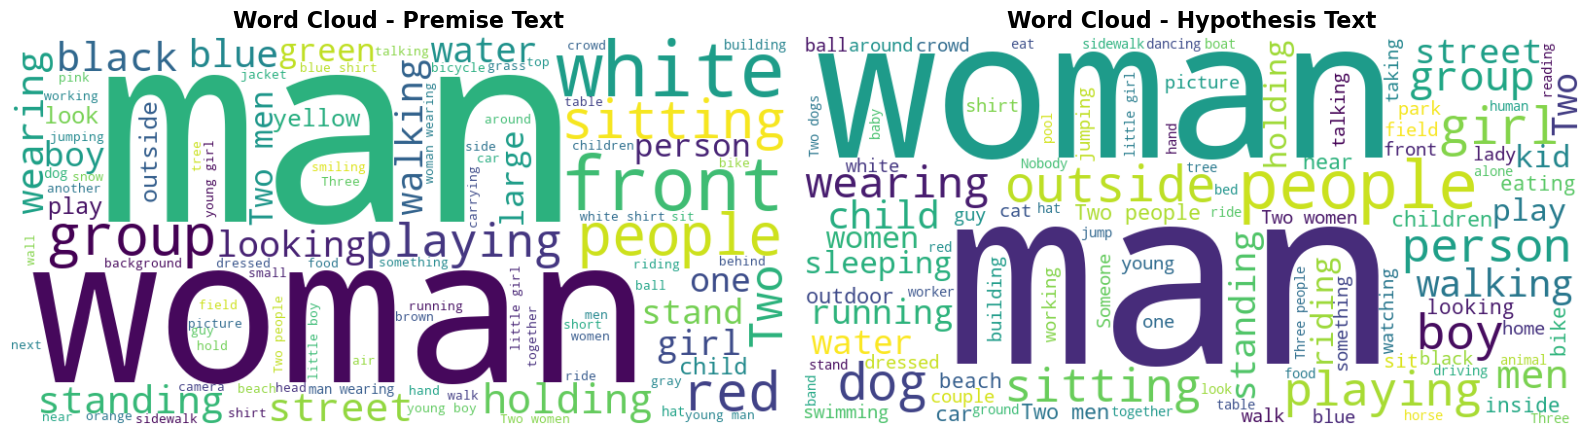


📊 Word Clouds by Label (Hypothesis)


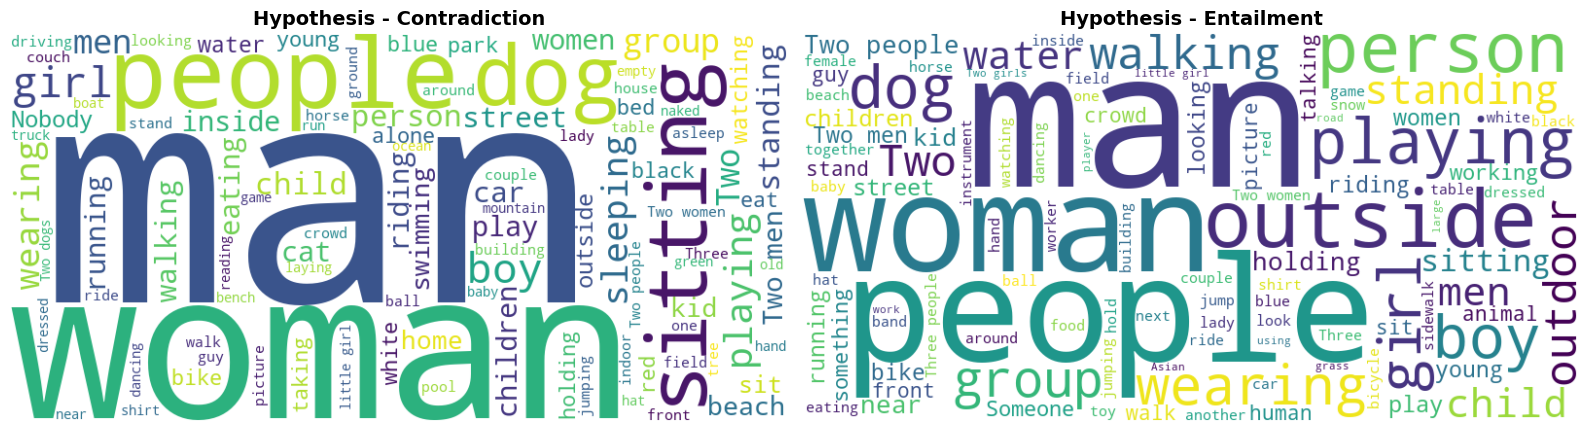

In [26]:
# Word Cloud EDA for Premise and Hypothesis
print("🔍 Generating Word Clouds for Text Analysis")

# Combine all premise texts and hypothesis texts
premise_text = ' '.join(df['Premise'].astype(str).tolist())
hypothesis_text = ' '.join(df['Hypothesis'].astype(str).tolist())

# Create word clouds with custom settings
wordcloud_settings = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'stopwords': STOPWORDS,
    'max_words': 100,
    'colormap': 'viridis',
    'contour_width': 1,
    'contour_color': 'steelblue'
}

# Generate word cloud for Premise
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
wc_premise = WordCloud(**wordcloud_settings).generate(premise_text)
plt.imshow(wc_premise, interpolation='bilinear')
plt.title('Word Cloud - Premise Text', fontsize=16, fontweight='bold')
plt.axis('off')

# Generate word cloud for Hypothesis
plt.subplot(1, 2, 2)
wc_hypothesis = WordCloud(**wordcloud_settings).generate(hypothesis_text)
plt.imshow(wc_hypothesis, interpolation='bilinear')
plt.title('Word Cloud - Hypothesis Text', fontsize=16, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Word clouds by label for hypothesis
print("\n📊 Word Clouds by Label (Hypothesis)")

# Get unique labels
labels = df['Label'].unique()

# Create word clouds for each label
fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

for i, label in enumerate(labels):
    # Filter hypothesis text by label
    hypo_by_label = df[df['Label'] == label]['Hypothesis'].astype(str).tolist()
    hypo_text_by_label = ' '.join(hypo_by_label)

    # Generate word cloud
    wc_label = WordCloud(**wordcloud_settings).generate(hypo_text_by_label)
    axes[i].imshow(wc_label, interpolation='bilinear')
    axes[i].set_title(f'Hypothesis - {label.title()}', fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Text stats & cues


[EDA] Text length — Premise
Chars: count    11739.00
mean        64.32
std         27.41
min         12.00
25%         45.00
50%         58.00
75%         77.00
max        311.00
Words: count    11739.00
mean        12.56
std          5.34
min          2.00
25%          9.00
50%         11.00
75%         15.00
max         60.00


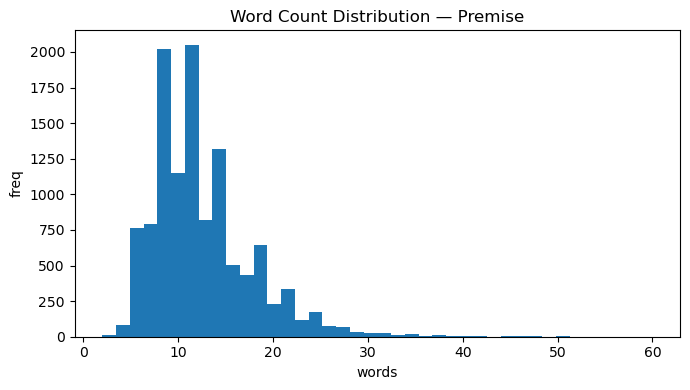


[EDA] Text length — Hypothesis
Chars: count    11739.00
mean        34.82
std         14.08
min          4.00
25%         25.00
50%         32.00
75%         41.00
max        168.00
Words: count    11739.00
mean         6.94
std          2.74
min          2.00
25%          5.00
50%          6.00
75%          8.00
max         30.00


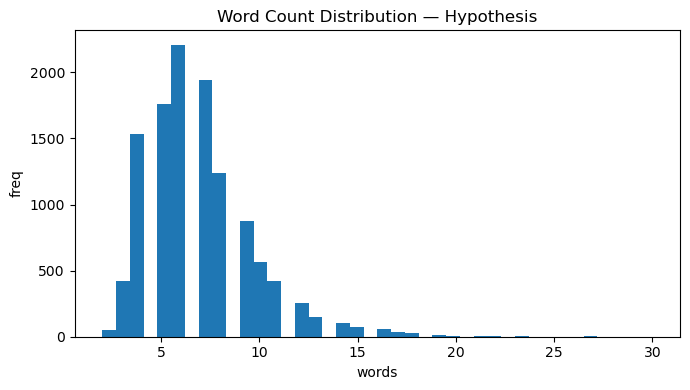

In [27]:
for col in ["Premise","Hypothesis"]:
    print(f"\n[EDA] Text length — {col}")
    lengths = df[col].astype(str).map(lambda s: len(s))
    words   = df[col].astype(str).map(lambda s: len(simple_tokenize(s)))
    print("Chars:", lengths.describe().round(2).to_string())
    print("Words:", words.describe().round(2).to_string())
    plt.figure(figsize=(7,4)); plt.hist(words, bins=40)
    plt.title(f"Word Count Distribution — {col}")
    plt.xlabel("words"); plt.ylabel("freq"); plt.tight_layout(); plt.show()


### Lexical overlap (Jaccard) between Premise and Hypothesis

In [28]:
def jaccard(a, b):
    sa, sb = set(simple_tokenize(a)), set(simple_tokenize(b))
    if not sa and not sb: return 0.0
    return len(sa & sb) / max(1, len(sa | sb))

In [29]:
df["lex_jaccard_prem_hypo"] = [
    jaccard(p, h) for p,h in zip(df["Premise"], df["Hypothesis"])
]
print("\n[EDA] Lexical Jaccard Premise↔Hypothesis (overall)")
print(df["lex_jaccard_prem_hypo"].describe().round(3).to_string())

print("\nPer-label mean Jaccard:")
print(df.groupby("Label")["lex_jaccard_prem_hypo"].mean().round(3).to_string())



[EDA] Lexical Jaccard Premise↔Hypothesis (overall)
count    11739.000
mean         0.238
std          0.178
min          0.000
25%          0.111
50%          0.200
75%          0.333
max          1.000

Per-label mean Jaccard:
Label
contradiction    0.190
entailment       0.285


### Negation cues (often strong for contradiction)

In [30]:
df["neg_prem"] = df["Premise"].map(negation_count)
df["neg_hypo"] = df["Hypothesis"].map(negation_count)
print("\nPer-label mean negation counts:")
print(df.groupby("Label")[["neg_prem","neg_hypo"]].mean().round(3).to_string())



Per-label mean negation counts:
               neg_prem  neg_hypo
Label                            
contradiction     0.004     0.044
entailment        0.004     0.005


In [31]:
print("Labels after sampling:")
print(df["Label"].unique())
print(f"Count: {len(df['Label'].unique())}")

Labels after sampling:
['contradiction' 'entailment']
Count: 2


### Image integrity & stats

In [32]:
print("\n[EDA] Image integrity")
corrupted = []
for p in df["image_path"]:
    try:
        with Image.open(p) as im:
            im.verify()
    except Exception as e:
        corrupted.append((p, str(e)))
print("Corrupted images:", len(corrupted))
if corrupted[:5]:
    print("Examples:", corrupted[:5])



[EDA] Image integrity
Corrupted images: 0


### Size & aspect


Image size/ratio describe:
              w         h    aspect
count  11739.00  11739.00  11739.00
mean     459.17    395.68      1.23
std       67.92     74.42      0.36
min      164.00    112.00      0.33
25%      384.00    333.00      0.77
50%      500.00    375.00      1.33
75%      500.00    500.00      1.50
max      500.00    500.00      4.46


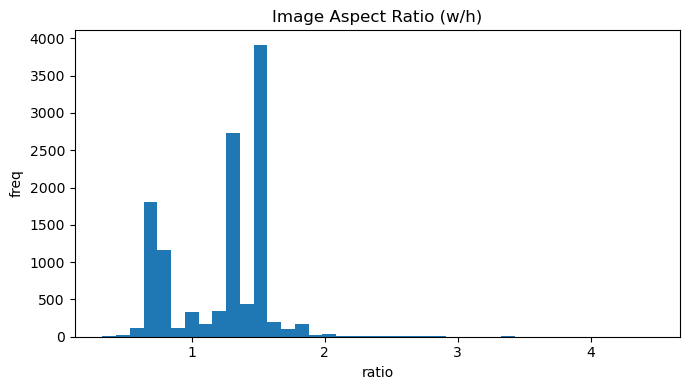

In [33]:
def size_stats(path):
    with Image.open(path) as im:
        im = ImageOps.exif_transpose(im)
        w,h = im.size
        return w,h, (w/h if h else np.nan)

rows = []
for _,r in df.iterrows():
    try:
        w,h,ar = size_stats(r["image_path"])
        rows.append({"Label": r["Label"], "w": w, "h": h, "aspect": ar})
    except Exception:
        pass
img_stats = pd.DataFrame(rows)
print("\nImage size/ratio describe:")
print(img_stats[["w","h","aspect"]].describe().round(2).to_string())

plt.figure(figsize=(7,4)); plt.hist(img_stats["aspect"].dropna(), bins=40)
plt.title("Image Aspect Ratio (w/h)"); plt.xlabel("ratio"); plt.ylabel("freq")
plt.tight_layout(); plt.show()


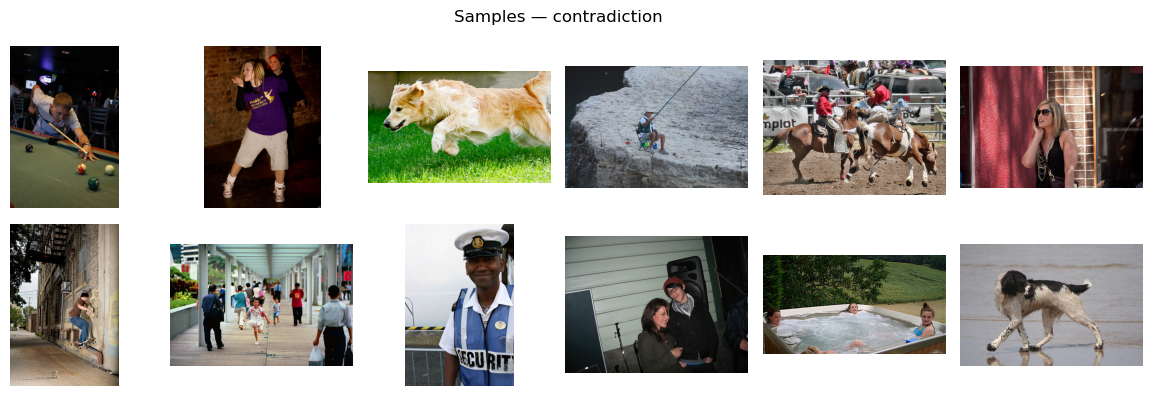

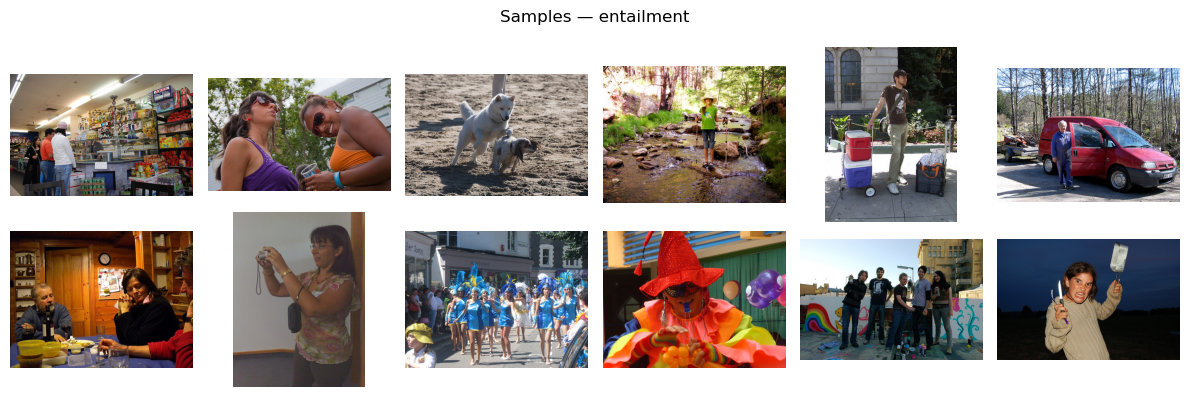

In [34]:
def montage(paths, n=12, cols=6, title="Montage"):
    paths = paths[:n]
    rows = math.ceil(len(paths)/cols) if cols else 1
    plt.figure(figsize=(cols*2, rows*2))
    for i,p in enumerate(paths):
        try:
            img = Image.open(p).convert("RGB")
            plt.subplot(rows, cols, i+1)
            plt.imshow(img); plt.axis("off")
        except: pass
    plt.suptitle(title); plt.tight_layout(); plt.show()

for lbl in label_names:
    subset = df[df["Label"]==lbl]["image_path"].sample(
        min(12, sum(df["Label"]==lbl)), random_state=SEED).tolist()
    if subset:
        montage(subset, n=len(subset), cols=6, title=f"Samples — {lbl}")


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import hashlib

# ---------- 1️⃣ Hashing helper (MD5) ----------
def md5_file(path, chunk_size=8192):
    try:
        h = hashlib.md5()
        with open(path, "rb") as f:
            while chunk := f.read(chunk_size):
                h.update(chunk)
        return h.hexdigest()
    except Exception:
        return None

# ---------- 2️⃣ Attach image_md5 if missing ----------
if "image_md5" not in df.columns:
    tqdm.pandas(desc="Hashing images")
    df["image_md5"] = df["image_path"].astype(str).progress_apply(md5_file)

# ---------- 3️⃣ Keep only unique images by hash ----------
df_unique = df.drop_duplicates(subset=["image_md5"], keep="first").dropna(subset=["image_md5"]).reset_index(drop=True)
print(f"🧩 {len(df_unique)} unique images (from {len(df)} total rows)")

# ---------- 4️⃣ Helper: load + histogram ----------
def load_image(path, color_mode="rgb"):
    img = cv2.imread(str(path))
    if img is None:
        return None
    if color_mode == "rgb":
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_mode == "gray":
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def compute_average_histogram(df, img_col="image_path", color_mode="rgb", bins=256):
    all_hists = []

    for path in tqdm(df[img_col], desc="Computing histograms"):
        img = load_image(path, color_mode=color_mode)
        if img is None:
            continue

        if color_mode == "gray":
            hist = cv2.calcHist([img], [0], None, [bins], [0,256]).flatten()
        else:
            hist_r = cv2.calcHist([img], [0], None, [bins], [0,256]).flatten()
            hist_g = cv2.calcHist([img], [1], None, [bins], [0,256]).flatten()
            hist_b = cv2.calcHist([img], [2], None, [bins], [0,256]).flatten()
            hist = np.stack([hist_r, hist_g, hist_b], axis=1)

        # Normalize per image
        hist = hist / (hist.sum() + 1e-8)
        all_hists.append(hist)

    avg_hist = np.mean(np.stack(all_hists, axis=0), axis=0)
    return avg_hist

# ---------- 5️⃣ Plot ----------
def plot_average_histogram(avg_hist, color_mode="rgb"):
    bins = np.arange(len(avg_hist))
    plt.figure(figsize=(8,4))
    if color_mode == "gray":
        plt.plot(bins, avg_hist, color="black")
        plt.title("Average Grayscale Histogram (Unique Images)")
        plt.xlabel("Pixel intensity (0–255)")
        plt.ylabel("Normalized frequency")
    else:
        plt.plot(bins, avg_hist[:,0], color="r", label="Red")
        plt.plot(bins, avg_hist[:,1], color="g", label="Green")
        plt.plot(bins, avg_hist[:,2], color="b", label="Blue")
        plt.title("Average RGB Histogram (Unique Images)")
        plt.xlabel("Pixel intensity (0–255)")
        plt.ylabel("Normalized frequency")
        plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 6️⃣ Run ----------
# avg_hist = compute_average_histogram(df_unique, img_col="image_path", color_mode="rgb", bins=256)
# plot_average_histogram(avg_hist, color_mode="rgb")


🧩 9556 unique images (from 11739 total rows)


### USE & CLIP similarities

In [36]:
import pandas as pd
import numpy as np

# --- 0) sanity: required columns present?
req = {"Image_ID", "Label", "Hypothesis", "Premise", "image_path"}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"df is missing columns: {sorted(missing)}")

# --- 1) normalize Label text a bit for consistency
def norm_label(x):
    if pd.isna(x):
        return x
    return str(x).strip()

df = df.copy()
df["Label"] = df["Label"].map(norm_label)

# --- 2) define unique_labels automatically (sorted for stable id order)
unique_labels = sorted(df["Label"].dropna().unique().tolist())

# --- 3) create mappings
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

# --- 4) attach label_id
df["label_id"] = df["Label"].map(label2id).astype("Int64")  # stays NA if Label missing

# --- 5) keep only requested columns in preferred order
df_trained = df[["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]].copy()

# --- 6) inspect / export
print("✅ Label → id mapping:", label2id)
print("🧠 Unique labels:", unique_labels)


✅ Label → id mapping: {'contradiction': 0, 'entailment': 1}
🧠 Unique labels: ['contradiction', 'entailment']


In [37]:
print(df_trained)

         Image_ID          Label  \
0      2672705063  contradiction   
1       554526471  contradiction   
2       423375604  contradiction   
3        65847949  contradiction   
4      4888378070  contradiction   
...           ...            ...   
11734  3848368547     entailment   
11735  4648443136     entailment   
11736  2306799249     entailment   
11737  3495224860     entailment   
11738    97825959     entailment   

                                              Hypothesis  \
0                     Bicyclists ride on a country road.   
1              A group of people are eating on the beach   
2                           The woman is in the country.   
3                         Some women are skiing outside.   
4                           Fans are storming the field.   
...                                                  ...   
11734                    People are waiting for the bus.   
11735           A man is holding a statue over his head.   
11736  A man is trying to h

## Data cleaning and split

In [38]:
import pandas as pd

def clean_label(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and deduplicate a label map DataFrame.
    Removes NaNs, trims whitespace, drops duplicates, 
    and keeps only the required columns in order.
    
    Expected columns:
        ["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]
    """
    df = df.copy()

    # --- 1. Ensure required columns exist
    required = ["Image_ID", "Label", "Hypothesis", "Premise", "image_path", "label_id"]
    missing = set(required) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {sorted(missing)}")

    # --- 2. Drop rows with NaN in key columns
    df = df.dropna(subset=["Image_ID", "Label", "Hypothesis", "Premise", "image_path"])

    # --- 3. Convert to string and strip whitespace
    for col in ["Image_ID", "Label", "Hypothesis", "Premise", "image_path"]:
        df[col] = df[col].astype(str).str.strip()

    # --- 4. Remove duplicate rows (exact same Image_ID, Hypothesis, Premise)
    df = df.drop_duplicates(subset=["Image_ID", "Hypothesis", "Premise"], keep="first")

    # --- 5. Normalize label text (optional: lowercase)
    df["Label"] = df["Label"].str.lower()

    # --- 6. Reorder columns
    df = df[required]

    # --- 7. Reset index
    df = df.reset_index(drop=True)

    print(f"✅ Cleaned: {len(df)} rows, {df['Image_ID'].nunique()} unique images")
    return df


In [39]:
clean_df = clean_label(df_trained)

✅ Cleaned: 11739 rows, 9556 unique images


In [40]:
clean_df.head()

,Image_ID,Label,Hypothesis,Premise,image_path,label_id
0,2672705063,contradiction,Bicyclists ride on a country road.,Several bicyclists are riding their bikes in a...,./A2_Data/A2_Images/2672705063.jpg,0
1,554526471,contradiction,A group of people are eating on the beach,A woman is leading an exercise group on the se...,./A2_Data/A2_Images/554526471.jpg,0
2,423375604,contradiction,The woman is in the country.,a woman in the city holds a big purse,./A2_Data/A2_Images/423375604.jpg,0
3,65847949,contradiction,Some women are skiing outside.,Four women are gathered near a green table on ...,./A2_Data/A2_Images/65847949.jpg,0
4,4888378070,contradiction,Fans are storming the field.,random people in the stands.,./A2_Data/A2_Images/4888378070.jpg,0


array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

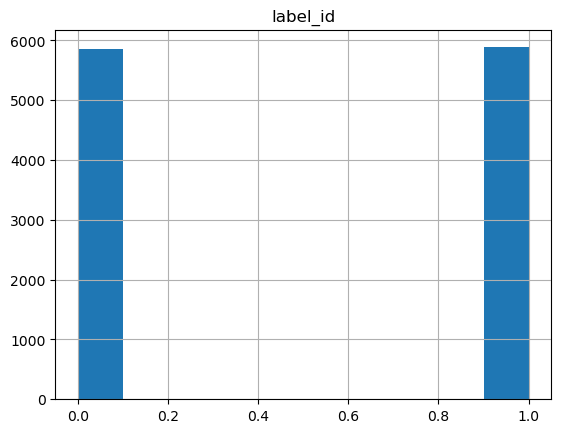

In [41]:
clean_df.hist()

In [42]:
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd

def grouped_split(
    df: pd.DataFrame,
    group_col: str = "Image_ID",
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    random_state: int = 42,
):
    """
    Split DataFrame into train/val/test using GroupShuffleSplit,
    keeping all rows of each group (e.g. Image_ID) in the same split.

    Args:
        df (pd.DataFrame): cleaned dataset
        group_col (str): grouping column, e.g. 'Image_ID'
        train_size (float): fraction of groups for training
        val_size (float): fraction of groups for validation
        test_size (float): fraction of groups for test
        random_state (int): reproducibility seed

    Returns:
        (train_df, val_df, test_df)
    """
    total = train_size + val_size + test_size
    if not abs(total - 1.0) < 1e-6:
        raise ValueError(f"train+val+test must sum to 1. Got {total:.2f}")

    groups = df[group_col].values

    # 🟩 Split 1: Train vs (Val+Test)
    gss1 = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    train_idx, temp_idx = next(gss1.split(df, groups=groups))
    train_df = df.iloc[train_idx].reset_index(drop=True)
    temp_df  = df.iloc[temp_idx].reset_index(drop=True)

    # 🟨 Split 2: Val vs Test (split temp 50:50 because val=test=15%)
    gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
    val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df[group_col].values))
    val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
    test_df = temp_df.iloc[test_idx].reset_index(drop=True)

    # 🧾 Summary
    print(f"✅ Split complete ({len(df):,} rows total)")
    print(f"  Train: {len(train_df):,} rows | {train_df[group_col].nunique():,} unique {group_col}s")
    print(f"  Val:   {len(val_df):,} rows | {val_df[group_col].nunique():,} unique {group_col}s")
    print(f"  Test:  {len(test_df):,} rows | {test_df[group_col].nunique():,} unique {group_col}s")

    return train_df, val_df, test_df


In [43]:
df.info

<bound method DataFrame.info of          Image_ID          Label  \
0      2672705063  contradiction   
1       554526471  contradiction   
2       423375604  contradiction   
3        65847949  contradiction   
4      4888378070  contradiction   
...           ...            ...   
11734  3848368547     entailment   
11735  4648443136     entailment   
11736  2306799249     entailment   
11737  3495224860     entailment   
11738    97825959     entailment   

                                              Hypothesis  \
0                     Bicyclists ride on a country road.   
1              A group of people are eating on the beach   
2                           The woman is in the country.   
3                         Some women are skiing outside.   
4                           Fans are storming the field.   
...                                                  ...   
11734                    People are waiting for the bus.   
11735           A man is holding a statue over his head

In [44]:
train_df, val_df, test_df = grouped_split(clean_df, group_col="Image_ID", random_state=42)

✅ Split complete (11,739 rows total)
  Train: 8,203 rows | 6,689 unique Image_IDs
  Val:   1,756 rows | 1,433 unique Image_IDs
  Test:  1,780 rows | 1,434 unique Image_IDs


In [45]:
train_df.columns

Index(['Image_ID', 'Label', 'Hypothesis', 'Premise', 'image_path', 'label_id'], dtype='object')

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

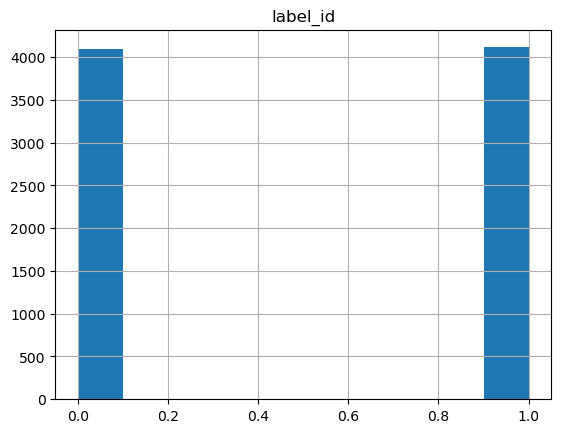

In [46]:
train_df.hist()

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

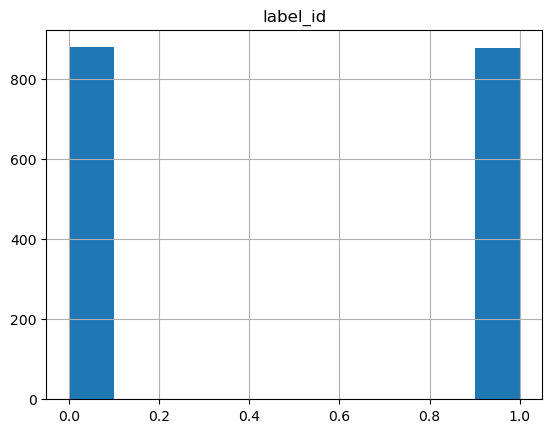

In [47]:
val_df.hist()

array([[<Axes: title={'center': 'label_id'}>]], dtype=object)

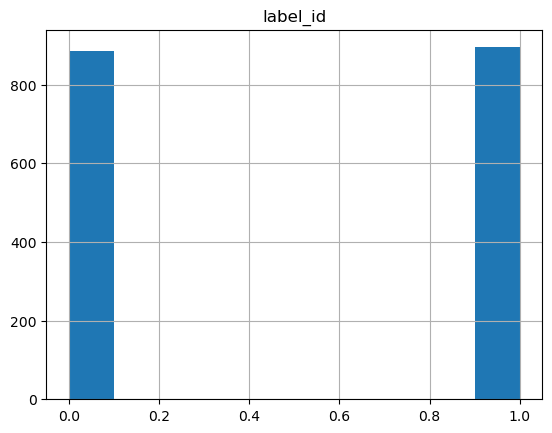

In [48]:
test_df.hist()

## Image augmenation 

In [49]:
# !pip install -U keras-cv keras-nlp tfclip ftfy

## Evaluation frame work (goal:...)

In [50]:
train_df.head()

,Image_ID,Label,Hypothesis,Premise,image_path,label_id
0,2672705063,contradiction,Bicyclists ride on a country road.,Several bicyclists are riding their bikes in a...,./A2_Data/A2_Images/2672705063.jpg,0
1,554526471,contradiction,A group of people are eating on the beach,A woman is leading an exercise group on the se...,./A2_Data/A2_Images/554526471.jpg,0
2,65847949,contradiction,Some women are skiing outside.,Four women are gathered near a green table on ...,./A2_Data/A2_Images/65847949.jpg,0
3,2450461962,contradiction,Man playing accordian in front of people in wh...,Man playing violin in front of people in what ...,./A2_Data/A2_Images/2450461962.jpg,0
4,4408862587,contradiction,A woman and her cat walk toward the man and hi...,A woman and a child with a backpack walk down ...,./A2_Data/A2_Images/4408862587.jpg,0


In [51]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [52]:
import os, json, hashlib, random, math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

try:
    from tfclip import create_model_and_transforms
    TFCLIP_AVAILABLE = True
except Exception:
    print("⚠️ Install tfclip with: pip install tfclip")
    TFCLIP_AVAILABLE = False

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("TF:", tf.__version__)

TF: 2.19.1


In [53]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

TensorFlow version: 2.19.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True


In [54]:

IMAGE_SIZE    = (224,224)
BATCH_SIZE    = 32
EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 10
LR_STAGE1     = 1e-3
LR_STAGE2     = 1e-5


## Data Prprofessosr

In [55]:
train_df.columns

Index(['Image_ID', 'Label', 'Hypothesis', 'Premise', 'image_path', 'label_id'], dtype='object')

In [56]:
print("🔍 LABEL ANALYSIS")
print("="*40)
print(f"Unique labels in train_df: {sorted(train_df['label_id'].unique())}")
print(f"Label counts: {train_df['label_id'].value_counts().sort_index()}")
print(f"Expected NUM_CLASSES: {len(train_df['label_id'].unique())}")

🔍 LABEL ANALYSIS
Unique labels in train_df: [np.int64(0), np.int64(1)]
Label counts: label_id
0    4089
1    4114
Name: count, dtype: Int64
Expected NUM_CLASSES: 2


In [57]:
pd

<module 'pandas' from '/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pandas/__init__.py'>

In [58]:
BATCH_SIZE = 32

In [59]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, metrics
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
import cv2
import ftfy
from tfclip import create_model_and_transforms
from tqdm import tqdm

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [60]:
TEXT_MODE = "hypothesis+premise"  # "hypothesis" or "hypothesis+premise"

# Training config (from your existing setup)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 10
LR_STAGE1 = 1e-3
LR_STAGE2 = 1e-5

NUM_CLASSES = len(train_df['label_id'].unique())

print(f"✅ Configuration:")
print(f"   NUM_CLASSES: {NUM_CLASSES}")
print(f"   TEXT_MODE: {TEXT_MODE}")

✅ Configuration:
   NUM_CLASSES: 2
   TEXT_MODE: hypothesis+premise


In [61]:
# Using tfclip instead of KerasHub presets
print("Using tfclip. Presets are defined by model/pretrained names in tfclip.")
print("Examples:")
print("  - MODEL_NAME='ViT-B-32-quickgelu', PRETRAINED='openai'")
print("  - MODEL_NAME='ViT-B-32', PRETRAINED='laion400m_e31'")

Using tfclip. Presets are defined by model/pretrained names in tfclip.
Examples:
  - MODEL_NAME='ViT-B-32-quickgelu', PRETRAINED='openai'
  - MODEL_NAME='ViT-B-32', PRETRAINED='laion400m_e31'


In [62]:
import os
# Force CPU to avoid CuDNN mismatch during sanity check
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np, keras
from tfclip import create_model_and_transforms

MODEL_NAME = "ViT-B-32-quickgelu"
PRETRAINED = "openai"
backbone_model, image_prep, text_prep = create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)

In [63]:
backbone_model.summary()

Model: "clip"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ vision_images       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_image_norm   │ (None, None,      │          0 │ vision_images[0]… │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_embed  │ (None, None,      │  2,359,296 │ vision_image_nor… │
│ (Conv2D)            │ None, 768)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_flatt… │ (None, 49, 768)   │          0 │ vision_patch_emb… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_cls    │ (None, 50, 768)   │        768 │ vision_patch_fla… │
│ (AddClassToken)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_texts          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_pos    │ (None, 50, 768)   │     38,400 │ vision_patch_cls… │
│ (ImagePositionEmbe… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_token_embed    │ (None, None, 512) │ 25,296,896 │ text_texts[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_norm   │ (None, 50, 768)   │      1,536 │ vision_patch_pos… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_token_pos      │ (None, None, 512) │     39,424 │ text_token_embed… │
│ (TextPositionEmbed… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_layer_0_att… │ (None, 50, 768)   │      1,536 │ vision_patch_nor… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_layer_0_attn_… │ (None, None, 512) │      1,024 │ text_token_pos[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_layer_0_att… │ (None, 50, 768)   │  2,362,368 │ vision_layer_0_a… │
│ (MultiHeadAttentio… │                   │            │ vision_layer_0_a… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_layer_0_attn_… │ (None, None, 512) │  1,050,624 │ text_layer_0_att… │
│ (MultiHeadAttentio… │                   │            │ text_layer_0_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_layer_0_att… │ (None, 50, 768)   │          0 │ vision_patch_nor… │
│ (Add)               │                   │            │ vision_layer_0_a… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_layer_0_attn_… │ (None, None, 512) │          0 │ text_token_pos[0… │
│ (Add)               │                   │            │ text_layer_0_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_layer_0_mlp… │ (None, 50, 768)   │      1,536 │ vision_layer_0_a

 Total params: 151,277,313 (577.08 MB)

 Trainable params: 151,277,313 (577.08 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# !pip install --upgrade tfclip

In [65]:
from keras import Model, layers
import tensorflow as tf

from keras import Model, layers
import tensorflow as tf

class CLIPEntailmentModel(Model):
    """CLIP entailment model with explicit shape handling for XLA compatibility."""

    def __init__(self, clip_backbone, num_classes=3, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        
        # Get normalized outputs BEFORE pooling
        vision_norm = clip_backbone.get_layer('vision_head_norm').output  # (B, 50, 768)
        text_norm = clip_backbone.get_layer('text_head_norm').output      # (B, 77, 512)
        
        print(f"Vision norm output: {vision_norm.shape}")
        print(f"Text norm output: {text_norm.shape}")
        
        # Vision: extract CLS token (index 0)
        vision_pooled = layers.Lambda(
            lambda x: x[:, 0, :], 
            name='vision_cls'
        )(vision_norm)
        
        # Text: mean pooling with explicit reduction
        text_pooled = layers.Lambda(
            lambda x: tf.reduce_mean(x, axis=1),  # Explicit mean over sequence
            name='text_mean'
        )(text_norm)
        
        print(f"Vision pooled: {vision_pooled.shape}")
        print(f"Text pooled: {text_pooled.shape}")
        
        # Project to 512 dims
        vision_proj = layers.Dense(512, use_bias=False, name='vision_proj')(vision_pooled)
        text_proj = layers.Dense(512, use_bias=False, name='text_proj')(text_pooled)
        
        # L2 normalize with epsilon for stability
        vision_norm_out = layers.Lambda(
            lambda x: tf.nn.l2_normalize(x, axis=-1, epsilon=1e-12),
            name='vision_l2'
        )(vision_proj)
        
        text_norm_out = layers.Lambda(
            lambda x: tf.nn.l2_normalize(x, axis=-1, epsilon=1e-12),
            name='text_l2'
        )(text_proj)
        
        # Concatenate - both should be (B, 512)
        combined = layers.Concatenate(axis=-1, name='entail_concat')([vision_norm_out, text_norm_out])
        
        # Classification head
        x = layers.Dense(512, activation='relu', name='entail_dense1')(combined)
        x = layers.Dropout(0.1, name='entail_dropout')(x)
        outputs = layers.Dense(num_classes, activation='softmax', name='entail_classifier')(x)
        
        # Build model
        super().__init__(
            inputs=clip_backbone.inputs,
            outputs=outputs,
            name='clip_entailment_model'
        )
        
        # Freeze contrastive head
        for layer in self.layers:
            if 'head_sim' in layer.name or 'head_prob' in layer.name:
                layer.trainable = False
        
        print(f"\n✓ Model created: Combined (B, 1024) → Output (B, {num_classes})")

# Create the model
print('Creating CLIP entailment model...')
model = CLIPEntailmentModel(clip_backbone=backbone_model, num_classes=len(label2id))
print(f'Classes: {list(label2id.keys())}')

# Sanity test on a single batch if available
try:
    sample = next(iter(train_dataset.take(1)))
    inputs, labels = sample
    out = model(inputs, training=False)
    print('Sanity output shape:', out.shape)
except Exception as e:
    print('Sanity test skipped/failed:', e)

Creating CLIP entailment model...
Vision norm output: (None, 50, 768)
Text norm output: (None, None, 512)
Vision pooled: (None, 768)
Text pooled: (None, 512)

✓ Model created: Combined (B, 1024) → Output (B, 2)
Classes: ['contradiction', 'entailment']
Sanity test skipped/failed: name 'train_dataset' is not defined


In [66]:
# import os, io, cv2, json, numpy as np, tensorflow as tf
# from tqdm import tqdm

# # ---------- 1) Helpers to build serializable features ----------
# def _bytes_feature(v):
#     if isinstance(v, type(tf.constant(0))):
#         v = v.numpy()
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[v]))

# def _int64_feature(v):
#     if isinstance(v, (list, tuple, np.ndarray)):
#         return tf.train.Feature(int64_list=tf.train.Int64List(value=list(np.array(v).astype(np.int64))))
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=[int(v)]))

# # ---------- 2) Tokenize a pair with CLIP's text_prep (fixed len 77) ----------
# def tokenize_pair(premise:str, hypothesis:str, max_length:int=77):
#     combined = f"{premise} [SEP] {hypothesis}"
#     toks = text_prep([combined])
#     tok  = next(iter(toks.values())) if isinstance(toks, dict) else toks
#     tok  = tok[0] if isinstance(tok, (list, tuple)) else tok[0]
#     tok  = np.array(tok, dtype=np.int32)
#     if tok.ndim == 2: tok = tok[0]
#     if tok.shape[0] > max_length: tok = tok[:max_length]
#     if tok.shape[0] < max_length: tok = np.pad(tok, (0, max_length - tok.shape[0]))
#     return tok.astype(np.int32)

# # ---------- 3) Write TFRecords from a DataFrame (with tqdm) ----------
# def write_tfrecords(df, tfrec_path:str, max_len:int=77):
#     os.makedirs(os.path.dirname(tfrec_path) or ".", exist_ok=True)
#     with tf.io.TFRecordWriter(tfrec_path) as w:
#         for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Writing {os.path.basename(tfrec_path)}"):
#             img_path = str(row['image_path'])
#             bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
#             if bgr is None:
#                 continue
#             rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
#             ok, buf = cv2.imencode('.jpg', rgb, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
#             if not ok: continue
#             img_bytes = buf.tobytes()

#             tok = tokenize_pair(str(row['Premise']), str(row['Hypothesis']), max_length=max_len)
#             y   = int(row['label_id'])

#             ex = tf.train.Example(features=tf.train.Features(feature={
#                 'image_bytes': _bytes_feature(img_bytes),
#                 'tokens': _int64_feature(tok.tolist()),
#                 'label': _int64_feature(y),
#             }))
#             w.write(ex.SerializeToString())
#     return tfrec_path

# # ---------- 3.1) Convenience: get-or-create TFRecord ----------
# def get_or_create_tfrecord(df, tfrec_path:str, max_len:int=77):
#     if tf.io.gfile.exists(tfrec_path):
#         return tfrec_path
#     return write_tfrecords(df, tfrec_path, max_len=max_len)

# # ---------- 4) (Optional) Light Albumentations for training ----------
# # NOTE: We apply augs at *input time* via tf.py_function to keep TFRecords clean.
# def _albu_augment_np(image, h: int, w: int, do_augment: bool) -> np.ndarray:
#     """
#     image: HxWxC (uint8) or TF EagerTensor
#     returns: HxWx3 uint8 (RGB), resized/cropped to (h, w)
#     """
#     import albumentations as A

#     # --- Ensure NumPy uint8, 3 channels, contiguous ---
#     # Convert TF tensor -> NumPy
#     if 'tensorflow' in str(type(image)):
#         image = image.numpy()
#     image = np.asarray(image)

#     # Handle grayscale inputs
#     if image.ndim == 2:
#         image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     elif image.ndim == 3 and image.shape[2] == 1:
#         image = np.repeat(image, 3, axis=2)

#     # Albumentations expects uint8 contiguous
#     if image.dtype != np.uint8:
#         image = image.astype(np.uint8, copy=False)
#     image = np.ascontiguousarray(image)

#     # --- Light transforms ---
#     if do_augment:
#         transform = A.Compose([
#             A.SmallestMaxSize(max(h, w)),
#             A.RandomCrop(height=h, width=w),
#             A.HorizontalFlip(p=0.5),
#             A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
#             A.RGBShift(r_shift_limit=8, g_shift_limit=8, b_shift_limit=8, p=0.2),
#         ])
#     else:
#         transform = A.Compose([
#             A.SmallestMaxSize(max(h, w)),
#             A.CenterCrop(height=h, width=w),
#         ])

#     try:
#         aug = transform(image=image)['image']
#     except Exception as e:
#         # Raise a super-clear error to debug data issues
#         raise RuntimeError(
#             f"Albumentations failed. "
#             f"shape={getattr(image, 'shape', None)}, dtype={getattr(image, 'dtype', None)}, "
#             f"ndim={getattr(image, 'ndim', None)}; error={e}"
#         ) from e

#     return aug

# def _apply_albu_tf(img_uint8, image_size, training: bool):
#     h, w = image_size
#     out = tf.py_function(
#         func=lambda x: _albu_augment_np(x, h, w, bool(training)),
#         inp=[img_uint8],
#         Tout=tf.uint8
#     )
#     # Make shape static for downstream ops
#     out.set_shape([h, w, 3])
#     return out

# # ---------- 5) Parse TFRecords back to tensors ----------
# def _parse_tfrecord_fn(proto, image_size=(224,224), max_len:int=77, training:bool=False):
#     spec = {
#         'image_bytes': tf.io.FixedLenFeature([], tf.string),
#         'tokens': tf.io.FixedLenFeature([max_len], tf.int64),
#         'label': tf.io.FixedLenFeature([], tf.int64),
#     }
#     ex = tf.io.parse_single_example(proto, spec)

#     # Decode as uint8; apply Albumentations (uint8->uint8); then to float32 [0,1]
#     img = tf.io.decode_jpeg(ex['image_bytes'], channels=3)  # uint8 [H,W,3], RGB
#     img = _apply_albu_tf(img, image_size, training=training)  # uint8 [h,w,3]
#     img = tf.image.convert_image_dtype(img, tf.float32)       # float32 in [0,1]

#     tokens = tf.cast(ex['tokens'], tf.int32)
#     label  = tf.cast(ex['label'], tf.int32)

#     return {'vision_images': img, 'text_texts': tokens}, label

# # ---------- 6) Build a tf.data pipeline from TFRecords ----------
# def make_tfrecord_dataset(tfrec_path: str, batch_size: int = 32, shuffle_buffer: int = 2048,
#                           image_size=(224, 224), max_len: int = 77, shuffle=True, 
#                           drop_remainder=True):
#     """Create a fresh dataset each time this is called"""
#     ds = tf.data.TFRecordDataset(tfrec_path, num_parallel_reads=tf.data.AUTOTUNE)
    
#     if shuffle:
#         ds = ds.shuffle(shuffle_buffer, reshuffle_each_iteration=True)
    
#     ds = ds.map(
#         lambda x: _parse_tfrecord_fn(x, image_size=image_size, max_len=max_len),
#         num_parallel_calls=tf.data.AUTOTUNE
#     )
    
#     # Add repeat() to make infinite dataset
#     ds = ds.repeat()  # This prevents "end of sequence" errors
    
#     opts = tf.data.Options()
#     opts.experimental_deterministic = False
#     ds = ds.with_options(opts)
    
#     return ds.batch(batch_size, drop_remainder=drop_remainder).prefetch(tf.data.AUTOTUNE)


In [67]:
# # Build TFRecords (train/val) and use them for training
# # 1) Write TFRecords (sharded optional)
# tfrec_train = get_or_create_tfrecord(train_df, 'data/train.tfrecord')
# tfrec_val   = get_or_create_tfrecord(val_df,   'data/val.tfrecord')

# # 2) Read TFRecords as datasets
# train_dataset = make_tfrecord_dataset(tfrec_train, batch_size=BATCH_SIZE, shuffle=True)
# val_dataset   = make_tfrecord_dataset(tfrec_val,   batch_size=BATCH_SIZE, shuffle=False)

In [68]:
# # ============================================================================
# print("\n" + "="*80)
# print("CHECKING TFRECORD FILES")
# print("="*80)

# def count_tfrecord_examples(tfrecord_path):
#     count = 0
#     for _ in tf.data.TFRecordDataset(tfrecord_path):
#         count += 1
#     return count

# train_count = count_tfrecord_examples('train.tfrecord')
# val_count = count_tfrecord_examples('val.tfrecord')

# print(f"✓ train.tfrecord: {train_count} examples ({os.path.getsize('train.tfrecord')/(1024**2):.1f} MB)")
# print(f"✓ val.tfrecord: {val_count} examples ({os.path.getsize('val.tfrecord')/(1024**2):.1f} MB)")

# BATCH_SIZE = 32
# steps_per_epoch = train_count // BATCH_SIZE
# validation_steps = val_count // BATCH_SIZE

# print(f"\nWith batch_size={BATCH_SIZE}:")
# print(f"  steps_per_epoch: {steps_per_epoch}")
# print(f"  validation_steps: {validation_steps}")
# print("="*80)

In [69]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import albumentations as A
from typing import Dict, Tuple, Generator

# ============================================================================
# DATA GENERATOR
# ============================================================================

class CLIPDataGenerator:
    """Generator for CLIP model inputs with image augmentation."""
    
    def __init__(
        self,
        df: pd.DataFrame,
        text_preprocessor,  # text_prep from tfclip
        image_size: Tuple[int, int] = (224, 224),
        max_text_length: int = 77,
        augment: bool = False,
        shuffle: bool = True,
        seed: int = 42
    ):
        self.df = df.copy().reset_index(drop=True)
        self.text_preprocessor = text_preprocessor
        self.image_size = image_size
        self.max_text_length = max_text_length
        self.augment = augment
        self.shuffle = shuffle
        self.seed = seed
        self.indices = np.arange(len(self.df))
        
        # Setup augmentations
        if self.augment:
            self.transform = A.Compose([
                A.SmallestMaxSize(max(image_size)),
                A.RandomCrop(height=image_size[0], width=image_size[1]),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(
                    brightness_limit=0.2, 
                    contrast_limit=0.2, 
                    p=0.5
                ),
                A.HueSaturationValue(
                    hue_shift_limit=10, 
                    sat_shift_limit=20, 
                    val_shift_limit=10, 
                    p=0.3
                ),
                A.OneOf([
                    A.GaussNoise(var_limit=(5, 15), p=1),
                    A.GaussianBlur(blur_limit=(3, 5), p=1),
                ], p=0.2),
            ])
        else:
            self.transform = A.Compose([
                A.SmallestMaxSize(max(image_size)),
                A.CenterCrop(height=image_size[0], width=image_size[1]),
            ])
    
    def _load_and_preprocess_image(self, image_path: str) -> np.ndarray:
        """Load and preprocess a single image."""
        # Load image
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"Failed to load image: {image_path}")
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply augmentations
        img = self.transform(image=img)['image']
        
        # Convert to float32 [0, 1]
        img = img.astype(np.float32) / 255.0
        
        return img
    
    def _tokenize_text(self, premise: str, hypothesis: str) -> np.ndarray:
        """Tokenize text pair using CLIP tokenizer."""
        # Combine premise and hypothesis
        combined_text = f"{premise} [SEP] {hypothesis}"
        
        # Tokenize using CLIP's text preprocessor
        tokens = self.text_preprocessor([combined_text])
        
        # Extract token ids
        if isinstance(tokens, dict):
            token_ids = next(iter(tokens.values()))
        else:
            token_ids = tokens
        
        # Handle batch dimension
        if isinstance(token_ids, (list, tuple)):
            token_ids = token_ids[0]
        
        # Convert to numpy
        token_ids = np.array(token_ids, dtype=np.int32)
        
        # Remove batch dim if present
        if token_ids.ndim == 2:
            token_ids = token_ids[0]
        
        # Truncate or pad to max_length
        if len(token_ids) > self.max_text_length:
            token_ids = token_ids[:self.max_text_length]
        elif len(token_ids) < self.max_text_length:
            token_ids = np.pad(
                token_ids, 
                (0, self.max_text_length - len(token_ids)),
                constant_values=0
            )
        
        return token_ids.astype(np.int32)
    
    def __call__(self) -> Generator:
        """Generator function for tf.data.Dataset."""
        # Shuffle indices at start of each epoch
        if self.shuffle:
            np.random.RandomState(self.seed).shuffle(self.indices)
        
        for idx in self.indices:
            row = self.df.iloc[idx]
            
            try:
                # Load and preprocess image
                image = self._load_and_preprocess_image(row['image_path'])
                
                # Tokenize text
                tokens = self._tokenize_text(row['Premise'], row['Hypothesis'])
                
                # Get label
                label = np.int32(row['label_id'])
                
                # Yield in the format: (inputs_dict, label)
                yield (
                    {
                        'vision_images': image,
                        'text_texts': tokens
                    },
                    label
                )
                
            except Exception as e:
                print(f"Warning: Failed to process row {idx}: {e}")
                continue
    
    def __len__(self):
        return len(self.df)


# ============================================================================
# DATASET BUILDER
# ============================================================================

def create_dataset_from_generator(
    df: pd.DataFrame,
    text_preprocessor,
    image_size: Tuple[int, int] = (224, 224),
    batch_size: int = 32,
    max_text_length: int = 77,
    augment: bool = False,
    shuffle: bool = True,
    drop_remainder: bool = True,
    seed: int = 42
) -> tf.data.Dataset:
    """
    Create a tf.data.Dataset from a DataFrame using a generator.
    
    Args:
        df: DataFrame with columns ['image_path', 'Premise', 'Hypothesis', 'label_id']
        text_preprocessor: CLIP text preprocessor
        image_size: Target image size (H, W)
        batch_size: Batch size
        max_text_length: Maximum text token length
        augment: Whether to apply data augmentation
        shuffle: Whether to shuffle data
        drop_remainder: Whether to drop last incomplete batch
        seed: Random seed
    
    Returns:
        tf.data.Dataset yielding (inputs_dict, labels)
    """
    # Create generator
    generator = CLIPDataGenerator(
        df=df,
        text_preprocessor=text_preprocessor,
        image_size=image_size,
        max_text_length=max_text_length,
        augment=augment,
        shuffle=shuffle,
        seed=seed
    )
    
    # Define output signature
    output_signature = (
        {
            'vision_images': tf.TensorSpec(
                shape=(*image_size, 3), 
                dtype=tf.float32
            ),
            'text_texts': tf.TensorSpec(
                shape=(max_text_length,), 
                dtype=tf.int32
            )
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
MAX_TEXT_LENGTH = 77

print("Creating training dataset...")
train_dataset = create_dataset_from_generator(
    df=train_df,
    text_preprocessor=text_prep,  # from tfclip
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    max_text_length=MAX_TEXT_LENGTH,
    augment=True,      # Enable augmentation for training
    shuffle=True,      # Shuffle training data
    drop_remainder=True,
    seed=42
)

print("Creating validation dataset...")
val_dataset = create_dataset_from_generator(
    df=val_df,
    text_preprocessor=text_prep,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    max_text_length=MAX_TEXT_LENGTH,
    augment=False,     # No augmentation for validation
    shuffle=False,     # No shuffle for validation
    drop_remainder=False,
    seed=42
)

print("Creating test dataset...")
test_dataset = create_dataset_from_generator(
    df=test_df,
    text_preprocessor=text_prep,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    max_text_length=MAX_TEXT_LENGTH,
    augment=False,
    shuffle=False,
    drop_remainder=False,
    seed=42
)

# Verify dataset
print("\n" + "="*60)
print("DATASET VERIFICATION")
print("="*60)

for inputs, labels in train_dataset.take(1):
    print(f"Batch structure:")
    print(f"  Images shape: {inputs['vision_images'].shape}")
    print(f"  Tokens shape: {inputs['text_texts'].shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"\nData types:")
    print(f"  Images dtype: {inputs['vision_images'].dtype}")
    print(f"  Tokens dtype: {inputs['text_texts'].dtype}")
    print(f"  Labels dtype: {labels.dtype}")
    print(f"\nValue ranges:")
    print(f"  Images: [{inputs['vision_images'].numpy().min():.3f}, {inputs['vision_images'].numpy().max():.3f}]")
    print(f"  Tokens: [{inputs['text_texts'].numpy().min()}, {inputs['text_texts'].numpy().max()}]")
    print(f"  Labels: {np.unique(labels.numpy())}")

print("="*60)


Creating training dataset...
Creating validation dataset...
Creating test dataset...

DATASET VERIFICATION


/tmp/ipykernel_31564/3706699752.py:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 15), p=1),
2025-10-09 05:41:24.666898: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Batch structure:
  Images shape: (32, 224, 224, 3)
  Tokens shape: (32, 77)
  Labels shape: (32,)

Data types:
  Images dtype: <dtype: 'float32'>
  Tokens dtype: <dtype: 'int32'>
  Labels dtype: <dtype: 'int32'>

Value ranges:
  Images: [0.000, 1.000]
  Tokens: [0, 49407]
  Labels: [0 1]


2025-10-09 05:41:47.776572: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Modeling

In [70]:
train_df.shape

(8203, 6)

In [71]:
# Compile the model
LEARNING_RATE = 0.000005
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top_2_accuracy")
    ]
)

# Model summary
print("Model summary:")
model.summary()

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        mode="max"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        mode="max"
    ),
    keras.callbacks.TensorBoard(
        log_dir="./logs",
        histogram_freq=1
    )
]

print("Model compiled with callbacks ready!")

Model summary:


Model: "clip_entailment_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ vision_images       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_image_norm   │ (None, None,      │          0 │ vision_images[0]… │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_embed  │ (None, None,      │  2,359,296 │ vision_image_nor… │
│ (Conv2D)            │ None, 768)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_flatt… │ (None, 49, 768)   │          0 │ vision_patch_emb… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_cls    │ (None, 50, 768)   │        768 │ vision_patch_fla… │
│ (AddClassToken)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_texts          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_pos    │ (None, 50, 768)   │     38,400 │ vision_patch_cls… │
│ (ImagePositionEmbe… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_token_embed    │ (None, None, 512) │ 25,296,896 │ text_texts[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_patch_norm   │ (None, 50, 768)   │      1,536 │ vision_patch_pos… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_token_pos      │ (None, None, 512) │     39,424 │ text_token_embed… │
│ (TextPositionEmbed… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_layer_0_att… │ (None, 50, 768)   │      1,536 │ vision_patch_nor… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_layer_0_attn_… │ (None, None, 512) │      1,024 │ text_token_pos[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_layer_0_att… │ (None, 50, 768)   │  2,362,368 │ vision_layer_0_a… │
│ (MultiHeadAttentio… │                   │            │ vision_layer_0_a… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_layer_0_attn_… │ (None, None, 512) │  1,050,624 │ text_layer_0_att… │
│ (MultiHeadAttentio… │                   │            │ text_layer_0_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_layer_0_att… │ (None, 50, 768)   │          0 │ vision_patch_nor… │
│ (Add)               │                   │            │ vision_layer_0_a… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_layer_0_attn_… │ (None, None, 512) │          0 │ text_token_pos[0… │
│ (Add)               │                   │            │ text_layer_0_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_layer_0_mlp… │ (None, 50, 768)   │      1,536 │ vision_layer_0_a

 Total params: 151,803,138 (579.08 MB)

 Trainable params: 151,803,138 (579.08 MB)

 Non-trainable params: 0 (0.00 B)

Model compiled with callbacks ready!


In [77]:
import tensorflow as tf
from tensorflow import keras

# One-stage training scaffold for Optuna later
# Expects train_ds and val_ds as tf.data.Dataset yielding (inputs, labels)
# Inputs must match the model signature: for tfclip typically {"vision_images": ..., "text_texts": ...}
import math
import tensorflow as tf

# Unfreeze a percentage of layers (by trainable weights presence order)
def unfreeze_percentage(model: tf.keras.Model, percent: float) -> None:
    """Unfreezes the last `percent` of layers that have trainable weights.
    percent in [0,1]. 0 -> freeze all; 1 -> unfreeze all.
    """
    percent = float(max(0.0, min(1.0, percent)))
    # Gather layers that have trainable variables
    layers_with_weights = [l for l in model.layers if l.trainable_weights]
    if not layers_with_weights:
        # Fallback: consider all layers
        layers_with_weights = list(model.layers)
    k = max(0, math.floor(len(layers_with_weights) * percent))
    cutoff = len(layers_with_weights) - k
    for idx, layer in enumerate(layers_with_weights):
        layer.trainable = idx >= cutoff
    # Ensure BN-like layers remain in inference mode if desired (optional)
    # for l in model.layers:
    #     if isinstance(l, (tf.keras.layers.BatchNormalization,)):
    #         l.trainable = False

print("unfreeze_percentage ready.")
def run_one_stage_training(model, train_ds, val_ds, percent_unfreeze=0.2, lr=1e-4, epochs=1):
    # Unfreeze a portion of the model
    unfreeze_percentage(model, percent_unfreeze)

    # Compile
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    steps_per_epoch    = len(train_df) // BATCH_SIZE
    validation_steps   = len(val_df)   // BATCH_SIZE
    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
    )
    return history

print("run_one_stage_training ready. Provide train_ds/val_ds to use it.")

unfreeze_percentage ready.
run_one_stage_training ready. Provide train_ds/val_ds to use it.


In [ ]:
# Create checkpoint directory
import os
os.makedirs("./checkpoints", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

# Train the model
print("Starting CLIP fine-tuning...")
history = run_one_stage_training(
    model=model,
    train_ds=train_dataset,
    val_ds=val_dataset,
    percent_unfreeze=0.2,      # Unfreeze last 20% of layers
    lr=1e-4,
    epochs=5,
    # steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    # from_logits=False,         # Your model uses softmax
    # verbose=1
)

print("Training completed!")

# Save the final model
model.save("./models/clip_entailment_final.keras")
print("Model saved to ./models/clip_entailment_final.keras")

Starting CLIP fine-tuning...
Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 265s 963ms/step - acc: 0.6738 - loss: 0.6055 - val_acc: 0.6794 - val_loss: 0.5924
Epoch 2/5


2025-10-09 05:48:14.086279: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-10-09 05:48:14.086314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3421067036287335425
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


256/256 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6794 - val_loss: 0.5924
Epoch 3/5
197/256 ━━━━━━━━━━━━━━━━━━━━ 33s 572ms/step - acc: 0.7111 - loss: 0.5621

In [ ]:
# # First, let's inspect the model structure and data
# print("="*80)
# print("1. INSPECTING CLIP BACKBONE")
# print("="*80)

# # Check backbone structure
# print(f"\nBackbone inputs: {clip_backbone.inputs}")
# print(f"Backbone outputs: {clip_backbone.outputs}")
# print(f"Backbone output shapes: {[out.shape for out in clip_backbone.outputs]}")

# # Check all head layers
# print("\n2. HEAD LAYERS:")
# for layer_name in ['vision_head_out', 'vision_head_proj', 'vision_head_norm', 
#                    'text_head_out', 'text_head_pool', 'text_head_proj', 'text_head_norm']:
#     try:
#         layer = clip_backbone.get_layer(layer_name)
#         print(f"  {layer_name}: {layer.output_shape}")
#     except Exception as e:
#         print(f"  {layer_name}: NOT FOUND")

# print("\n" + "="*80)
# print("3. INSPECTING TRAINING DATA")
# print("="*80)

# # Get a sample batch from training data
# for batch in train_dataset.take(1):
#     if isinstance(batch, tuple):
#         inputs, labels = batch
#         print(f"\nBatch structure: (inputs, labels)")
#         print(f"Labels shape: {labels.shape}")
#         print(f"Labels dtype: {labels.dtype}")
        
#         if isinstance(inputs, dict):
#             print(f"\nInputs is a dict with keys: {inputs.keys()}")
#             for key, val in inputs.items():
#                 print(f"  {key}: shape={val.shape}, dtype={val.dtype}")
#                 print(f"         sample values: {val[0][:5] if len(val.shape) > 1 else val[0]}")
#         elif isinstance(inputs, (list, tuple)):
#             print(f"\nInputs is a tuple/list with {len(inputs)} elements:")
#             for i, inp in enumerate(inputs):
#                 print(f"  Input[{i}]: shape={inp.shape}, dtype={inp.dtype}")
#         else:
#             print(f"\nInputs: shape={inputs.shape}, dtype={inputs.dtype}")
#     else:
#         print(f"Batch structure: {type(batch)}")
#         print(f"Batch: {batch}")

# print("\n" + "="*80)
# print("4. TESTING MODEL WITH SAMPLE BATCH")
# print("="*80)

# # Test a forward pass with the sample batch
# try:
#     for batch in train_dataset.take(1):
#         inputs, labels = batch
        
#         # Extract images and tokens based on structure
#         if isinstance(inputs, dict):
#             images = inputs.get('vision_images')
#             tokens = inputs.get('text_texts')
#         else:
#             images, tokens = inputs
        
#         print(f"\nExtracted inputs:")
#         print(f"  Images: shape={images.shape}, dtype={images.dtype}")
#         print(f"  Tokens: shape={tokens.shape}, dtype={tokens.dtype}")
        
#         # Test image encoder
#         print("\n5. TESTING IMAGE ENCODER:")
#         img_model = models.Model(clip_backbone.inputs[0], 
#                                 clip_backbone.get_layer('vision_head_out').output)
#         img_out = img_model(images)
#         print(f"  vision_head_out output: shape={img_out.shape}, dtype={img_out.dtype}")
        
#         # Test text encoder
#         print("\n6. TESTING TEXT ENCODER:")
#         txt_model = models.Model(clip_backbone.inputs[1], 
#                                 clip_backbone.get_layer('text_head_out').output)
#         txt_out = txt_model(tokens)
#         print(f"  text_head_out output: shape={txt_out.shape}, dtype={txt_out.dtype}")
        
#         # Check if text output needs pooling
#         if len(txt_out.shape) == 3:
#             print(f"  -> Text is per-token (3D), needs pooling")
#         elif len(txt_out.shape) == 2:
#             batch_size_img = images.shape[0]
#             batch_size_txt = txt_out.shape[0]
#             print(f"  -> Text is 2D: batch_size={batch_size_txt}, embedding_dim={txt_out.shape[1]}")
#             print(f"  -> Image batch_size={batch_size_img}")
#             if batch_size_txt != batch_size_img:
#                 print(f"  -> MISMATCH! Text appears to be flattened ({batch_size_txt} = {batch_size_img} * {batch_size_txt // batch_size_img})")
        
#         # Try text_head_pool
#         print("\n7. TESTING TEXT_HEAD_POOL:")
#         try:
#             txt_pool_model = models.Model(clip_backbone.inputs[1], 
#                                          clip_backbone.get_layer('text_head_pool').output)
#             txt_pool_out = txt_pool_model(tokens)
#             print(f"  text_head_pool output: shape={txt_pool_out.shape}, dtype={txt_pool_out.dtype}")
#         except Exception as e:
#             print(f"  ERROR: {e}")
        
# except Exception as e:
#     import traceback
#     print(f"\nERROR during testing: {e}")
#     traceback.print_exc()

# print("\n" + "="*80)

### Model Evaluation

In [ ]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate on validation set
print("Evaluating model on validation set...")
val_predictions = []
val_true_labels = []

for (images, texts), labels in val_dataset:
    predictions = model.predict_on_batch((images, texts))
    predicted_classes = ops.argmax(predictions, axis=1).numpy()

    val_predictions.extend(predicted_classes)
    val_true_labels.extend(labels.numpy())

val_predictions = np.array(val_predictions)
val_true_labels = np.array(val_true_labels)

# Classification report
print("\nClassification Report:")
print(classification_report(val_true_labels, val_predictions,
                          target_names=list(label2id.keys())))

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label2id))
plt.xticks(tick_marks, list(label2id.keys()), rotation=45)
plt.yticks(tick_marks, list(label2id.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
from typing import Dict, Optional, Union
import os

def predict_large_dataset(
    model: tf.keras.Model,
    df: pd.DataFrame,
    text_preprocessor,
    image_size: tuple = (224, 224),
    batch_size: int = 32,
    max_text_length: int = 77,
    return_probabilities: bool = True,
    verbose: bool = True,
    save_path: Optional[str] = None
) -> pd.DataFrame:
    """
    Make predictions on a large dataset efficiently.
    
    Args:
        model: Trained Keras model
        df: DataFrame with columns ['image_path', 'Premise', 'Hypothesis', 'label_id']
        text_preprocessor: CLIP text preprocessor
        image_size: Image size for model input
        batch_size: Batch size for prediction
        max_text_length: Maximum text token length
        return_probabilities: Whether to return class probabilities
        verbose: Show progress bar
        save_path: Optional path to save results CSV
    
    Returns:
        DataFrame with original data + predictions
    """
    if verbose:
        print(f"🔮 Starting prediction on {len(df):,} samples...")
        print(f"   Batch size: {batch_size}")
        print(f"   Expected batches: {int(np.ceil(len(df) / batch_size))}")
    
    # Create prediction dataset (no augmentation, no shuffle)
    pred_dataset = create_dataset_from_generator(
        df=df,
        text_preprocessor=text_preprocessor,
        image_size=image_size,
        batch_size=batch_size,
        max_text_length=max_text_length,
        augment=False,  # No augmentation for prediction
        shuffle=False,  # Keep original order
        drop_remainder=False,  # Keep all samples
        seed=42
    )
    
    # Calculate number of batches
    num_batches = int(np.ceil(len(df) / batch_size))
    
    # Collect predictions
    all_predictions = []
    all_probabilities = []
    
    # Predict with progress bar
    if verbose:
        pbar = tqdm(total=num_batches, desc="Predicting", unit="batch")
    
    for batch_inputs, _ in pred_dataset.take(num_batches):
        # Get predictions for batch
        batch_probs = model.predict_on_batch(batch_inputs)
        batch_preds = np.argmax(batch_probs, axis=1)
        
        all_predictions.extend(batch_preds)
        all_probabilities.extend(batch_probs)
        
        if verbose:
            pbar.update(1)
    
    if verbose:
        pbar.close()
    
    # Convert to arrays
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    
    # Ensure we have exactly len(df) predictions
    all_predictions = all_predictions[:len(df)]
    all_probabilities = all_probabilities[:len(df)]
    
    # Create results dataframe
    results_df = df.copy()
    results_df['predicted_label_id'] = all_predictions
    
    # Map label ids to label names
    if 'Label' in df.columns:
        id2label = {v: k for k, v in label2id.items()}
        results_df['predicted_label'] = results_df['predicted_label_id'].map(id2label)
    
    # Add probabilities if requested
    if return_probabilities:
        for i, label_name in enumerate(sorted(label2id.keys())):
            results_df[f'prob_{label_name}'] = all_probabilities[:, i]
    
    # Add confidence score (max probability)
    results_df['confidence'] = np.max(all_probabilities, axis=1)
    
    # Add correctness flag if ground truth available
    if 'label_id' in df.columns:
        results_df['is_correct'] = (
            results_df['label_id'] == results_df['predicted_label_id']
        )
        accuracy = results_df['is_correct'].mean()
        if verbose:
            print(f"\n✓ Prediction complete!")
            print(f"   Accuracy: {accuracy:.4f} ({results_df['is_correct'].sum()}/{len(df)})")
    else:
        if verbose:
            print(f"\n✓ Prediction complete!")
    
    # Save results if path provided
    if save_path:
        os.makedirs(os.path.dirname(save_path) or '.', exist_ok=True)
        results_df.to_csv(save_path, index=False)
        if verbose:
            print(f"   Results saved to: {save_path}")
    
    return results_df



In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def create_fresh_model(num_classes=3):
    """Create a new model instance for each trial."""
    # Recreate backbone
    backbone_model, _, _ = create_model_and_transforms(
        MODEL_NAME, 
        pretrained=PRETRAINED
    )
    
    # Build entailment model
    model = CLIPEntailmentModel(
        clip_backbone=backbone_model, 
        num_classes=num_classes
    )
    return model

def objective(trial):
    """Optuna objective function."""
    # Clear previous models
    tf.keras.backend.clear_session()
    
    # Suggest hyperparameters
    percent_unfreeze = trial.suggest_float("percent_unfreeze", 0.1, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    
    # Create model with trial-specific dropout (you'd need to modify CLIPEntailmentModel)
    model = create_fresh_model(num_classes=len(label2id))
    
    # Calculate steps
    steps_per_epoch = len(train_df) // BATCH_SIZE
    validation_steps = len(val_df) // BATCH_SIZE
    
    try:
        # Train with suggested hyperparameters
        history = run_one_stage_training(
            model=model,
            train_ds=train_dataset,
            val_ds=val_dataset,
            percent_unfreeze=percent_unfreeze,
            lr=lr,
            epochs=10,  # Can also tune this
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            from_logits=False,
            verbose=0  # Silent for Optuna
        )
        
        # Return best validation accuracy
        val_acc = max(history.history['val_acc'])
        
        # Report intermediate values for pruning
        for epoch, acc in enumerate(history.history['val_acc']):
            trial.report(acc, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        return val_acc
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0  # Return worst score on failure

# Run Optuna study
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=3)
)

study.optimize(objective, n_trials=20, timeout=3600)  # 20 trials or 1 hour

# Best hyperparameters
print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
print(f"Best validation accuracy: {study.best_value:.4f}")
print(f"Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Visualize results
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()